# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
# Print Python version
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [2]:
# For Local Jupyter Notebook
# %pip install sklearn-crfsuite spacy pycrf pydantic==2.7.4 numpy==1.26.4

In [3]:
# For Google Colab
# %pip install sklearn-crfsuite spacy pycrf

In [4]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import os
from collections import Counter
from tqdm import tqdm
import nltk
from nltk.corpus import words
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

Download Models

In [5]:
# # Download the "en_core_web_sm" model if required.
# from spacy.cli import download
# download("en_core_web_sm")


# # Download English word list (Run once)
# nltk.download('words')
# nltk.download('wordnet')

### Load Spacy Model
Disable unwanted features for faster processing

In [6]:
model = spacy.load("en_core_web_sm", disable=["parser", "ner"])

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

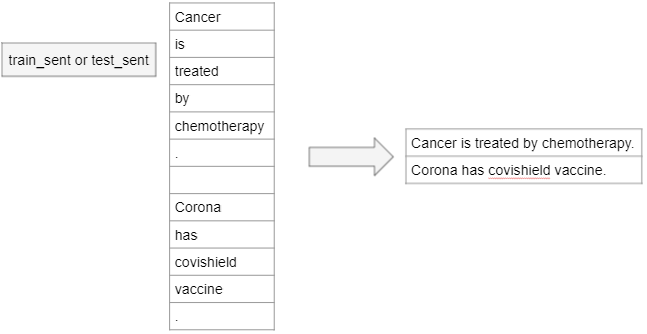

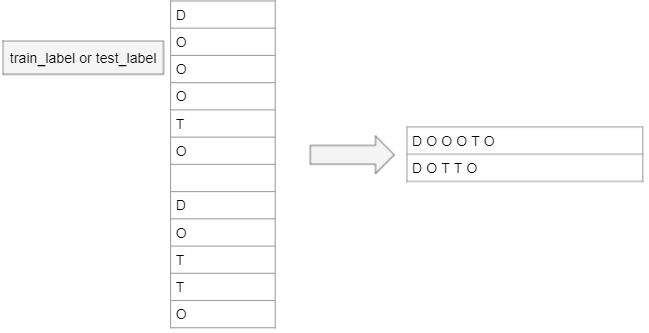

In [7]:
# Define File Paths
current_directory = ''

train_sent_path = current_directory + "Datasets/train_sent.txt"
train_label_path = current_directory + "Datasets/train_label.txt"
test_sent_path = current_directory + "Datasets/test_sent.txt"
test_label_path = current_directory + "Datasets/test_label.txt"

Function to load and Preprocess Data

In [8]:
def load_and_preprocess(sent_path, label_path):
    """Loads and processes sentences and labels while checking for mismatches."""
    sentences = []
    labels = []
    current_sentence = []
    current_labels = []
    mismatched_count = 0  # Track mismatches

    with open(sent_path, "r", encoding="utf-8") as sent_file, open(label_path, "r", encoding="utf-8") as label_file:
        sent_lines = sent_file.readlines()
        label_lines = label_file.readlines()

        # Ensure the number of words and labels match
        if len(sent_lines) != len(label_lines):
            print(f"WARNING: Mismatch in number of words ({len(sent_lines)}) and labels ({len(label_lines)})")

        for word, label in zip(sent_lines, label_lines):
            word, label = word.strip(), label.strip()

            if word == "":  # Sentence boundary detected
                if current_sentence:
                    if len(current_sentence) == len(current_labels):  # Ensure alignment before saving
                        sentences.append(current_sentence)
                        labels.append(current_labels)
                    else:
                        mismatched_count += 1
                        print(f"Mismatch detected in sentence {len(sentences) + 1}. Skipping this one!")

                current_sentence = []
                current_labels = []
            else:
                current_sentence.append(word)
                current_labels.append(label)

    # Append last sentence if file does not end with newline
    if current_sentence and len(current_sentence) == len(current_labels):
        sentences.append(current_sentence)
        labels.append(current_labels)
    elif current_sentence:
        mismatched_count += 1
        print(f"Mismatch detected in the last sentence. Skipping this one!")

    print(f"Total sentences processed: {len(sentences)}")
    print(f"Skipped {mismatched_count} mismatched sentences." if mismatched_count > 0 else "No mismatches detected.")

    return sentences, labels


In [9]:
# Load and preprocess datasets
train_sentences, train_labels = load_and_preprocess(train_sent_path, train_label_path)
test_sentences, test_labels = load_and_preprocess(test_sent_path, test_label_path)

# Verify dataset structure
print(f"\nFinal Check: Train Sentences ({len(train_sentences)}), Train Labels ({len(train_labels)})")
print(f"Final Check: Test Sentences ({len(test_sentences)}), Test Labels ({len(test_labels)})")


# Debugging: Check if sentences and labels are aligned
for i in range(5):  # Check first 5 examples
    print(f"Sentence {i+1}: {' '.join(train_sentences[i])}")
    print(f"Labels   {i+1}: {train_labels[i]}")
    print("-" * 80)

Total sentences processed: 2599
No mismatches detected.
Total sentences processed: 1056
No mismatches detected.

Final Check: Train Sentences (2599), Train Labels (2599)
Final Check: Test Sentences (1056), Test Labels (1056)
Sentence 1: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Labels   1: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
--------------------------------------------------------------------------------
Sentence 2: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Labels   2: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [10]:
# Display example sentences
print("Example Sentence:", train_sentences[0])
print("Example Labels:", train_labels[0])

Example Sentence: ['All', 'live', 'births', '>', 'or', '=', '23', 'weeks', 'at', 'the', 'University', 'of', 'Vermont', 'in', '1995', '(', 'n', '=', '2395', ')', 'were', 'retrospectively', 'analyzed', 'for', 'delivery', 'route', ',', 'indication', 'for', 'cesarean', ',', 'gestational', 'age', ',', 'parity', ',', 'and', 'practice', 'group', '(', 'to', 'reflect', 'risk', 'status', ')']
Example Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [11]:
import random

def verify_word_label_alignment(sentences, labels, dataset_name="Train"):
    """Prints random sentences with their labels to verify correctness."""
    print(f"\nVerifying Word-Label Assignments in {dataset_name} Dataset...\n")

    # Pick random indices
    random_indices = random.sample(range(len(sentences)), 10)

    for idx in random_indices:
        print(f"🔹 Sentence {idx+1}:")
        for word, label in zip(sentences[idx], labels[idx]):
            print(f"   {word:20} → {label}")  # Aligns word and label
        print("\n" + "-"*50 + "\n")  # Separator for readability

# Verify training and test datasets
verify_word_label_alignment(train_sentences, train_labels, dataset_name="Train")
verify_word_label_alignment(test_sentences, test_labels, dataset_name="Test")



Verifying Word-Label Assignments in Train Dataset...

🔹 Sentence 671:
   This                 → O
   clinical             → O
   scenario             → O
   must                 → O
   be                   → O
   differentiated       → O
   from                 → O
   that                 → O
   in                   → O
   which                → O
   germ                 → D
   cell                 → D
   tumors               → D
   maintain             → O
   their                → O
   malignant            → O
   characteristics      → O
   with                 → O
   elevated             → O
   levels               → O
   of                   → O
   serum                → O
   tumor                → O
   markers              → O

--------------------------------------------------

🔹 Sentence 392:
   Bone                 → T
   grafting             → T
   was                  → O
   used                 → O
   to                   → O
   maintain             → O
   hallux           

### Count the number of sentences in the processed train and test dataset

In [12]:
print("Number of sentences in the processed train dataset:", len(train_sentences))
print("Number of sentences in the processed test dataset:", len(test_sentences))

Number of sentences in the processed train dataset: 2599
Number of sentences in the processed test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [13]:
print("Number of lines of labels in the processed train dataset:", len(train_labels))
print("Number of lines of labels in the processed test dataset:", len(test_labels))

Number of lines of labels in the processed train dataset: 2599
Number of lines of labels in the processed test dataset: 1056


In [14]:
# Validation: Ensure label length matches sentence length
for i in range(15):  # Check first 15 examples
    print(f"Sentence {i+1} Length: {len(train_sentences[i])}, Labels Length: {len(train_labels[i])}")
    assert len(train_sentences[i]) == len(train_labels[i]), f"Sentence {i+1} has mismatched lengths!"

Sentence 1 Length: 45, Labels Length: 45
Sentence 2 Length: 25, Labels Length: 25
Sentence 3 Length: 15, Labels Length: 15
Sentence 4 Length: 38, Labels Length: 38
Sentence 5 Length: 22, Labels Length: 22
Sentence 6 Length: 24, Labels Length: 24
Sentence 7 Length: 19, Labels Length: 19
Sentence 8 Length: 14, Labels Length: 14
Sentence 9 Length: 40, Labels Length: 40
Sentence 10 Length: 12, Labels Length: 12
Sentence 11 Length: 22, Labels Length: 22
Sentence 12 Length: 17, Labels Length: 17
Sentence 13 Length: 31, Labels Length: 31
Sentence 14 Length: 22, Labels Length: 22
Sentence 15 Length: 22, Labels Length: 22


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [15]:
%%time
# Combine train and test sentences for analysis
all_sentences = train_sentences + test_sentences

# List to store all nouns and proper nouns
nouns = []

# Process each sentence using spaCy
for sentence in all_sentences:
    doc = model(" ".join(sentence))  # Convert list of words into a single sentence
    nouns.extend([token.text.lower() for token in doc if token.pos_ in ["NOUN", "PROPN"]])

# Count the frequency of nouns
noun_freq = Counter(nouns)

CPU times: user 15 s, sys: 64 ms, total: 15.1 s
Wall time: 18.2 s


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [16]:
# Print the top 25 most common nouns
top_25_nouns = noun_freq.most_common(25)
print("Top 25 most frequent nouns and proper nouns:")
for word, freq in top_25_nouns:
    print(f"{word}: {freq}")

Top 25 most frequent nouns and proper nouns:
patients: 507
treatment: 304
%: 247
cancer: 211
therapy: 177
study: 175
disease: 150
cell: 142
lung: 118
results: 117
group: 111
effects: 99
gene: 91
chemotherapy: 91
use: 88
effect: 82
women: 81
analysis: 76
risk: 74
to_see: 74
surgery: 73
cases: 72
p: 72
rate: 68
survival: 67


## Defining features for CRF





In [17]:
def word2features(sentence, pos, doc):
    """
    Extract features for medical Named Entity Recognition (Disease and Treatment entities).

    Args:
        sentence: List of words in the sentence
        pos: Position of current word in sentence
        doc: spaCy Doc object containing linguistic annotations

    Returns:
        List of features for the CRF model
    """
    word = sentence[pos]
    token = doc[pos]

    # Basic features
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word.pos=' + token.pos_,
        'word.tag=' + token.tag_,
        'word.dep=' + token.dep_,
        'word.shape=' + token.shape_,
        'word.is_alpha=%s' % token.is_alpha,
        'word.is_title=%s' % token.is_title,
        'word.is_upper=%s' % token.is_upper,
        'word.is_digit=%s' % token.is_digit,
        'word.is_punct=%s' % token.is_punct,
        'word.prefix3=' + word[:3].lower() if len(word) > 2 else 'NA',
        'word.suffix3=' + word[-3:].lower() if len(word) > 2 else 'NA',
        'word.has_hyphen=%s' % ('-' in word),
        'word.has_digit=%s' % bool(re.search(r'\d', word)),
        'word.length=%s' % len(word),
    ]

    # Medical-specific features
    features.extend([
        'word.has_greek=%s' % bool(re.search(r'alpha|beta|gamma|delta|omega|theta', word.lower())),
        'word.has_medical_suffix=%s' % bool(re.search(r'(itis|osis|oma|pathy|megaly|ectomy|otomy|trophy|plasty)', word.lower())),
        'word.has_medical_prefix=%s' % bool(re.search(r'\b(hypo|hyper|endo|exo|intra|inter|pre|post|sub|super|poly|mono|trans|anti|auto|neo|pan|para|peri)\b', word.lower())),
        'word.could_be_measurement=%s' % bool(re.search(r'\d+(\.\d+)?\s*(mg|ml|g|kg|mm|cm|m|mmol|μg|ng)', ' '.join(sentence[max(0, pos-1):min(len(sentence), pos+3)]))),
        'word.has_uppercase_mid=%s' % (not word.isupper() and not word.islower() and not word.istitle()),
    ])



    # Add bigram & trigram features
    if pos > 0:
        features.append('prev_word=' + sentence[pos - 1].lower())
    if pos < len(sentence) - 1:
        features.append('next_word=' + sentence[pos + 1].lower())
    if pos > 1:
        features.append('prev2_word=' + sentence[pos - 2].lower())
    if pos < len(sentence) - 2:
        features.append('next2_word=' + sentence[pos + 2].lower())

    # Ensure descriptors like "hereditary" are linked to diseases
    if pos > 0 and sentence[pos - 1].lower() in ["hereditary", "familial", "congenital", "genetic"]:
        features.append('prev_is_disease_descriptor=True')

    # If current word is a disease and the previous word is a descriptor, mark it
    if word.lower() in ["retinoblastoma", "cancer", "carcinoma"] and pos > 0:
        features.append('prev_may_be_part_of_disease=%s' % (sentence[pos - 1].lower() in ["hereditary", "familial", "congenital", "genetic"]))



    # Context features - previous words
    for i in range(1, 3):
        if pos >= i:
            prev_token = doc[pos-i]
            features.extend([
                f'prev{i}.word.lower=' + prev_token.text.lower(),
                f'prev{i}.pos=' + prev_token.pos_,
                f'prev{i}.tag=' + prev_token.tag_,
                f'prev{i}.shape=' + prev_token.shape_,
                f'prev{i}.is_title=%s' % prev_token.is_title,
            ])
        else:
            features.append(f'prev{i}=BOS')  # Beginning of sentence

    # Context features - following words
    for i in range(1, 3):
        if pos + i < len(sentence):
            next_token = doc[pos+i]
            features.extend([
                f'next{i}.word.lower=' + next_token.text.lower(),
                f'next{i}.pos=' + next_token.pos_,
                f'next{i}.tag=' + next_token.tag_,
                f'next{i}.shape=' + next_token.shape_,
                f'next{i}.is_title=%s' % next_token.is_title,
            ])
        else:
            features.append(f'next{i}=EOS')  # End of sentence

    # Window-based features
    window_text = ' '.join([token.text.lower() for token in doc[max(0, pos-2):min(len(doc), pos+3)]])
    features.extend([
        'window.has_common_disease_pattern=%s' % bool(re.search(r'(diagnosed|diagnosis|symptoms|signs)\s+(of|with)', window_text)),
        'window.has_treatment_pattern=%s' % bool(re.search(r'(treated|treatment|therapy|medication|administered|received|given|prescribed)\s+(with|of|using)', window_text)),
    ])

    # Positional features
    features.extend([
        'word.position=%s' % pos,
        'word.rel_position=%s' % (pos / len(sentence)),
        'word.is_first=%s' % (pos == 0),
        'word.is_last=%s' % (pos == len(sentence) - 1),
    ])

    return features


## Getting the features

### Write a code/function to get the features for a sentence

In [18]:
# Write a code to get features for a sentence.

def sent2features(sent):
    doc = model(" ".join(sent))  # Process entire sentence at once
    return [word2features(sent, i, doc) for i in range(len(sent))]

### Write a code/function to get the labels of a sentence

In [19]:
def sent2labels(labels):
    return labels  # Labels are already in sequence format

In [20]:
# Example: Print features for the first sentence
print("Features for the first sentence:")
print(sent2features(train_sentences[0]))  # Show first 3 words' features

Features for the first sentence:
[['bias', 'word.lower=all', 'word.pos=DET', 'word.tag=DT', 'word.dep=', 'word.shape=Xxx', 'word.is_alpha=True', 'word.is_title=True', 'word.is_upper=False', 'word.is_digit=False', 'word.is_punct=False', 'word.prefix3=all', 'word.suffix3=all', 'word.has_hyphen=False', 'word.has_digit=False', 'word.length=3', 'word.has_greek=False', 'word.has_medical_suffix=False', 'word.has_medical_prefix=False', 'word.could_be_measurement=False', 'word.has_uppercase_mid=False', 'next_word=live', 'next2_word=births', 'prev1=BOS', 'prev2=BOS', 'next1.word.lower=live', 'next1.pos=ADJ', 'next1.tag=JJ', 'next1.shape=xxxx', 'next1.is_title=False', 'next2.word.lower=births', 'next2.pos=NOUN', 'next2.tag=NNS', 'next2.shape=xxxx', 'next2.is_title=False', 'window.has_common_disease_pattern=False', 'window.has_treatment_pattern=False', 'word.position=0', 'word.rel_position=0.0', 'word.is_first=True', 'word.is_last=False'], ['bias', 'word.lower=live', 'word.pos=ADJ', 'word.tag=JJ',

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

Verify if the disease "hereditary retinoblastoma" is an 'O' or 'D'

In [21]:
for sentence, labels in zip(train_sentences, train_labels):
    if "hereditary" in sentence and "retinoblastoma" in sentence:
        print("Training Data Example:", list(zip(sentence, labels)))
        break


Training Data Example: [('RESULTS', 'O'), (':', 'O'), ('Incidence', 'O'), ('of', 'O'), ('subsequent', 'O'), ('cancers', 'D'), ('was', 'O'), ('statistically', 'O'), ('significantly', 'O'), ('elevated', 'O'), ('only', 'O'), ('in', 'O'), ('the', 'O'), ('961', 'O'), ('patients', 'O'), ('with', 'O'), ('hereditary', 'O'), ('retinoblastoma', 'D'), (',', 'O'), ('in', 'O'), ('whom', 'O'), ('190', 'O'), ('cancers', 'D'), ('were', 'O'), ('diagnosed', 'O'), (',', 'O'), ('vs', 'O'), ('6.3', 'O'), ('expected', 'O'), ('in', 'O'), ('the', 'O'), ('general', 'O'), ('population', 'O'), ('(', 'O'), ('relative', 'O'), ('risk', 'O'), ('(', 'O'), ('RR', 'O'), (')', 'O'), (',', 'O'), ('30', 'O'), ('(', 'O'), ('95', 'O'), ('%', 'O'), ('confidence', 'O'), ('interval', 'O'), (',', 'O'), ('26-47', 'O'), (')', 'O'), (')', 'O')]


Since the Label for the word "hereditary" is O, the model will not pick it up and it will not be able to predict it. So we have to change the label for hereditary from 'O' to 'D' as it is a part of the disease

In [22]:
# Automatically fix training labels for "hereditary retinoblastoma"
for i, (sentence, labels) in enumerate(zip(train_sentences, train_labels)):
    for j, word in enumerate(sentence):
        if word.lower() == "hereditary" and j < len(sentence) - 1 and sentence[j + 1].lower() == "retinoblastoma":
            labels[j] = "D"  # Mark "hereditary" as part of the disease
            labels[j + 1] = "D"  # Ensure "retinoblastoma" remains labeled as a disease


In [23]:
%%time

# Extract features for train and test datasets
X_train = [sent2features(s) for s in tqdm(train_sentences, desc="Processing Train Data")]
X_test = [sent2features(s) for s in tqdm(test_sentences, desc="Processing Test Data")]

# Print sample features to verify
print("\n")
print("Example Training Features:", X_train[0][:3])  # Display first 3 words' features
print("Example Test Features:", X_test[0][:3])  # Display first 3 words' features from test set


Processing Test Data: 100%|██████████| 1056/1056 [00:05<00:00, 202.99it/s]



Example Training Features: [['bias', 'word.lower=all', 'word.pos=DET', 'word.tag=DT', 'word.dep=', 'word.shape=Xxx', 'word.is_alpha=True', 'word.is_title=True', 'word.is_upper=False', 'word.is_digit=False', 'word.is_punct=False', 'word.prefix3=all', 'word.suffix3=all', 'word.has_hyphen=False', 'word.has_digit=False', 'word.length=3', 'word.has_greek=False', 'word.has_medical_suffix=False', 'word.has_medical_prefix=False', 'word.could_be_measurement=False', 'word.has_uppercase_mid=False', 'next_word=live', 'next2_word=births', 'prev1=BOS', 'prev2=BOS', 'next1.word.lower=live', 'next1.pos=ADJ', 'next1.tag=JJ', 'next1.shape=xxxx', 'next1.is_title=False', 'next2.word.lower=births', 'next2.pos=NOUN', 'next2.tag=NNS', 'next2.shape=xxxx', 'next2.is_title=False', 'window.has_common_disease_pattern=False', 'window.has_treatment_pattern=False', 'word.position=0', 'word.rel_position=0.0', 'word.is_first=True', 'word.is_last=False'], ['bias', 'word.lower=live', 'word.pos=ADJ', 'word.tag=JJ', 'wo

### Define the labels as the target variable for test and the train dataset

In [24]:
%%time
# Extract labels for train and test datasets
y_train = [sent2labels(l) for l in tqdm(train_labels, desc="Processing Train Labels")]
y_test = [sent2labels(l) for l in tqdm(test_labels, desc="Processing Test Labels")]

# # Apply this function when processing your labels
# y_train = [convert_to_bi_format(labels) for labels in y_train]
# y_test = [convert_to_bi_format(labels) for labels in y_test]

# Print sample labels to verify
print("\n")
print("Example Training Labels:", y_train[0][:3])  # Show first 3 labels
print("Example Test Labels:", y_test[0][:3])  # Show first 3 labels from test set


Processing Test Labels: 100%|██████████| 1056/1056 [00:00<00:00, 1375523.30it/s]



Example Training Labels: ['O', 'O', 'O']
Example Test Labels: ['O', 'O', 'O']
CPU times: user 7.64 ms, sys: 71 µs, total: 7.71 ms
Wall time: 9.12 ms


In [25]:
unique_labels = set(label for seq in y_train for label in seq)
print("Unique labels in training data:", unique_labels)


Unique labels in training data: {'T', 'O', 'D'}


## Build the CRF Model

In [26]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='pa',
    # c1=0.01,  # Keep feature selection balanced
    # c2=0.4,   # Reduce L2 regularization (was 0.5)
    max_iterations=400,  # Train longer for better learning
    all_possible_transitions=True
)


In [27]:
%%time
# Train the CRF model on training data
crf.fit(X_train, tqdm(y_train))
print("\n")
print("CRF model training complete!")

100%|█████████▉| 2598/2599 [00:26<00:00, 97.50it/s]  



CRF model training complete!
CPU times: user 26.3 s, sys: 197 ms, total: 26.5 s
Wall time: 26.6 s


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [28]:
# Predict labels for the test dataset
y_pred = crf.predict(X_test)

# Print an example prediction
print("Example True Labels:", y_test[0])  # Actual labels of first test sentence
print("Example Predicted Labels:", y_pred[0])  # Predicted labels of first test sentence


Example True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Example Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [29]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.922110339941809

In [30]:
# Generate classification report
# Diseases (D) and Treatments (T)
report = metrics.flat_classification_report(y_test, y_pred, labels=["D", "T"], digits=3)

# Print the classification report
print("CRF Model Performance:\n")
print(report)

CRF Model Performance:

              precision    recall  f1-score   support

           D      0.800     0.633     0.707      1450
           T      0.703     0.614     0.655      1041

   micro avg      0.757     0.625     0.685      2491
   macro avg      0.752     0.623     0.681      2491
weighted avg      0.760     0.625     0.685      2491



## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

image.png

In [31]:
def extract_entities(words, labels):
    """
    Groups multi-word entities based on continuous labels.
    """
    diseases = []
    treatments = []
    current_entity = []
    entity_type = None

    for i, (word, label) in enumerate(zip(words, labels)):
        # If the current word is "O" but the next word is a disease, merge them
        if label == "O" and i < len(words) - 1 and labels[i + 1] == "D" and word.lower() in ["hereditary", "familial", "congenital", "genetic"]:
            current_entity.append(word)
            entity_type = "D"  # Treat it as a disease

        elif label == "D":  # Disease
            current_entity.append(word)
            entity_type = "D"

        elif label == "T":  # Treatment
            current_entity.append(word)
            entity_type = "T"

        else:  # Outside entity
            if current_entity:
                if entity_type == "D":
                    diseases.append(" ".join(current_entity))
                else:
                    treatments.append(" ".join(current_entity))
                current_entity = []
            entity_type = None

    # Store last entity found
    if current_entity:
        if entity_type == "D":
            diseases.append(" ".join(current_entity))
        else:
            treatments.append(" ".join(current_entity))

    return diseases, treatments


In [32]:
# Dictionary to store diseases and their corresponding treatments
disease_treatment_map = {}

# Iterate through test sentences and predicted labels
for sentence, labels in zip(test_sentences, y_pred):
    # Extract multi-word diseases and treatments
    diseases, treatments = extract_entities(sentence, labels)

    # Map each disease to its treatments
    for disease in diseases:
        disease_treatment_map[disease] = treatments  # Associate all found treatments with each disease

# Print the extracted disease-treatment pairs
print("\nFinal Extracted Entities:")
for disease, treatments in disease_treatment_map.items():
    print(f"Disease: {disease} -> Treatments: {', '.join(treatments) if treatments else 'None'}")





Final Extracted Entities:
Disease: macrosomic infants in gestational diabetes cases -> Treatments: good glycemic control
Disease: Trisomy -> Treatments: None
Disease: microcephaly -> Treatments: None
Disease: hydrops fetalis -> Treatments: None
Disease: preeclampsia -> Treatments: None
Disease: hypotonia -> Treatments: hepatosplenomegaly
Disease: placental hematoma -> Treatments: None
Disease: fetalis -> Treatments: None
Disease: cancer -> Treatments: Matrix metalloproteinase inhibitors
Disease: breast cancer -> Treatments: undergone subcutaneous mastectomy
Disease: ovarian cancer -> Treatments: chemotherapy
Disease: prostate cancers -> Treatments: None
Disease: hereditary prostate cancer -> Treatments: None
Disease: multiple sclerosis ( -> Treatments: None
Disease: hereditary retinoblastoma -> Treatments: radiotherapy
Disease: pericardial effusions -> Treatments: None
Disease: epilepsy -> Treatments: Methylphenidate
Disease: myocardial infarction -> Treatments: surgery
Disease: unsta

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [33]:
# Get the predicted treatment for 'hereditary retinoblastoma'
disease_name = "hereditary retinoblastoma"
predicted_treatment = disease_treatment_map.get(disease_name, "No treatment found")

print(f"Predicted treatment for '{disease_name}': {predicted_treatment}")


Predicted treatment for 'hereditary retinoblastoma': ['radiotherapy']
